In [1]:
## LOAD DATA

# Use pre-saved weights
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
import utilsHannes
import importlib
importlib.reload(utilsHannes)
from utilsHannes import CoverNetNoRelu
from utilsHannes import mean_pointwise_l2_distance
import torch
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import numpy as np



# Load data
version = "v1.0-mini" # v1.0-mini, v1.0-trainval
if version == "v1.0-mini":
    train_subset = "mini_train"
    val_subset = "mini_val"
elif version == "v1.0-trainval":
    train_subset = "train"
    val_subset = "val"
     
DATAROOT = "data/sets/nuscenes"
seconds_of_history_used = 2.0 # Half second steps

sequences_per_instance = "one_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")
print(f"shape of img_tensor = {img_tensor_list1[0].shape}")
# Squeeze for correct dimensions
for i, train_img_tensor in enumerate(img_tensor_list1):
    img_tensor_list1[i] = torch.nn.functional.interpolate(train_img_tensor, scale_factor=1/4, mode='bilinear')
#     img_tensor_list1[i] = torch.squeeze(train_img_tensor, dim=0)
#     agent_state_vector_list1[i] = torch.squeeze(agent_state_vector_list1[i], dim=0)
print(f"shape of img_tensor = {img_tensor_list1[0].shape}")
    
    
# sequences_per_instance = "non_overlapping_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
# img_tensor_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
# agent_state_vector_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
# future_xy_local_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")

# sequences_per_instance = "all_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
# img_tensor_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
# agent_state_vector_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
# future_xy_local_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")


# Model
backbone = ResNetBackbone('resnet50')
covernet = CoverNetNoRelu(backbone, num_modes=64)


/opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


shape of img_tensor = torch.Size([1, 3, 500, 500])
shape of img_tensor = torch.Size([1, 3, 125, 125])
hej from CoverNetNoRelu


In [12]:
## SPECIFY FILES AND MODEL
num_epochs = 299
file_path = f"tmpResults/results_epochs={num_epochs}"

# Load weights
covernet = copy.copy(covernet)
covernet.load_state_dict(torch.load(f'{file_path}_weights.pth'))

# Load lattice
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    lattice = np.array(pickle.load(f))
# print(f"Shape of lattice = {lattice.shape}")



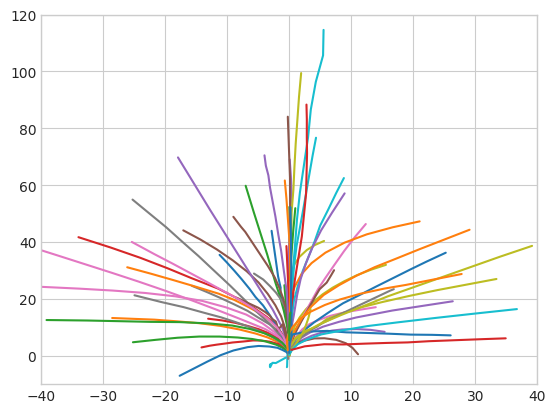

np.sum(outputValues) = 1.0000001192092896
predicted = tensor([0])
closest_lattice_index = 6
correct = tensor([False])


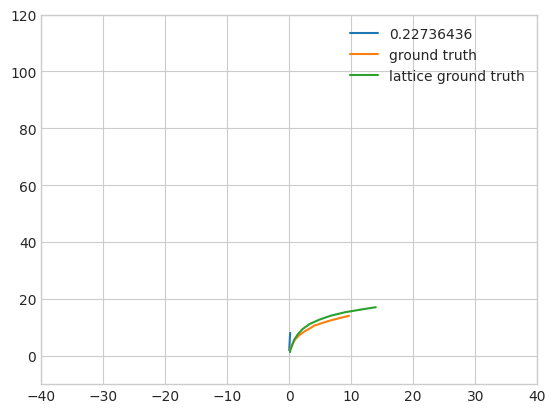

In [15]:
## PRINT PREDICTIONS


# Plot all trajectories
modes = np.arange(lattice.shape[0])
timesteps = np.arange(12) # 12 timesteps (which is maximum), can be reduced
for mode in modes:
    plt.plot(lattice[mode,timesteps,0],lattice[mode,timesteps,1])
plt.ylim([-10,120])
plt.xlim([-40,40])
plt.show()

### Top trajectories
nrOfTopTrajectories = 1

test_index = 40
### Get probabilities
logits = covernet(img_tensor_list1[test_index], agent_state_vector_list1[test_index])
softmaxy = torch.nn.Softmax(dim=1)
outputValues = softmaxy(logits).detach().numpy().squeeze()
print(f"np.sum(outputValues) = {np.sum(outputValues)}")

topProbabilitiesIndices = np.argsort(outputValues)[::-1][0:nrOfTopTrajectories]
topProbabilities = [outputValues[index] for index in topProbabilitiesIndices]
# print(f"topProbabilitiesIndices[0] = {topProbabilitiesIndices[0]}")

# Ground truth
ground_truth_trajectory = future_xy_local_list1[test_index]

# Lattice ground truth
_, predicted = torch.max(logits, 1) 
closest_lattice_index = mean_pointwise_l2_distance(torch.Tensor(lattice), ground_truth_trajectory)
print(f"predicted = {predicted}")
print(f"closest_lattice_index = {closest_lattice_index}")
correct = (predicted == closest_lattice_index)
print(f"correct = {correct}")

# Plot predictions
[plt.plot(lattice[mode,:,0],lattice[mode,:,1], label=topProbabilities[i]) for i, mode in enumerate(topProbabilitiesIndices)]
# Plot ground truth
plt.plot(ground_truth_trajectory[:,0], ground_truth_trajectory[:,1], label="ground truth")
# Plot lattice ground truth
plt.plot(lattice[closest_lattice_index,:,0],lattice[closest_lattice_index,:,1], label="lattice ground truth")

plt.ylim([-10,120]); plt.xlim([-40,40]); plt.legend(); plt.show()